In [1]:
import torch
import torch.nn.functional as F
import torchtext
import time
import pandas as pd

In [2]:
VOCABULARY_SIZE = 50000
LEARNING_RATE = 0.005
BATCH_SIZE = 125
NUM_EPOCHS = 25
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 125
HIDDEN_DIM = 250
NUM_CLASSES = 2

In [4]:
torch.device(0)

device(type='cuda', index=0)

In [5]:
#!pip install torchtext==0.9.1

In [6]:
#!python -m spacy download en_core_web_sm

In [3]:
### Defining the feature processing

TEXT = torchtext.legacy.data.Field(
    tokenize='spacy', # default splits on whitespace
    tokenizer_language='en_core_web_sm'
)

### Defining the label processing

LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)

In [8]:
trainingDF = pd.read_csv("training_corpus.csv")
trainingDF = trainingDF.drop(columns=["Stemmed_Review_Text"])
trainingDF.head()

,Review_Text,isPos
0,comment limited generally first season 195960b...,1
1,writer ever happened baby jane hush hush sweet...,1
2,curious know critics responded rousing inspiri...,1
3,agree mr caruso jr lanzas finest voice god off...,1
4,movie fictional soap opera fast funny say anyt...,1


In [9]:
testingDF = pd.read_csv("testing_corpus.csv")
testingDF = testingDF.drop(columns=["Stemmed_Review_Text"])
testingDF.head()

,Review_Text,isPos
0,movie excellent save scenes esposito enjoyed b...,1
1,take look faces alongside entrance jail theyre...,1
2,wonderful story seen families story acting pro...,1
3,almost 4 years events 911 asked comes mind day...,1
4,pretty clever wellacted version modern 30s wom...,1


In [10]:
trainingDF.to_csv("pure_training.csv", index=False)
testingDF.to_csv("pure_testing.csv", index=False)

In [4]:
trainingDF = pd.read_csv("pure_testing.csv")
trainingDF.head()

,Review_Text,isPos
0,movie excellent save scenes esposito enjoyed b...,1
1,take look faces alongside entrance jail theyre...,1
2,wonderful story seen families story acting pro...,1
3,almost 4 years events 911 asked comes mind day...,1
4,pretty clever wellacted version modern 30s wom...,1


In [5]:
testingDF = pd.read_csv("pure_testing.csv")
testingDF.head()

,Review_Text,isPos
0,movie excellent save scenes esposito enjoyed b...,1
1,take look faces alongside entrance jail theyre...,1
2,wonderful story seen families story acting pro...,1
3,almost 4 years events 911 asked comes mind day...,1
4,pretty clever wellacted version modern 30s wom...,1


In [6]:
Fields = [("REVIEW_TEXT", TEXT), ("isPos", LABEL)]

train_dataset = torchtext.legacy.data.TabularDataset(path="pure_training.csv", format="csv", skip_header=True, fields=Fields)
test_dataset = torchtext.legacy.data.TabularDataset(path="pure_testing.csv", format="csv", skip_header=True, fields=Fields)

In [14]:
print(vars(train_dataset.examples[0]))

{'REVIEW_TEXT': ['comment', 'limited', 'generally', 'first', 'season', '195960br', '/>br', '/>this', 'superb', 'series', 'one', 'first', 'televised', 'color', 'highly', 'influential', 'persuading', 'americans', 'buy', 'color', 'television', 'set', '$', '800', '1959', 'equivalent', '$', '3000', 'today', 'many', 'us', 'would', 'pay', 'much', 'privilege', 'watching', 'show', 'transmitted', 'cathode', 'ray', 'picture', 'tube', '17inch', 'screen', 'eleven', 'series', 'began', 'watched', 'beginningbr', '/>br', '/>watching', '50', 'years', 'later', 'several', 'things', 'come', 'mind', 'first', 'many', 'story', 'lines', 'involve', 'comstock', 'lode', 'heyday', 'silver', 'mining', 'dates', '1859', '1859', 'weapons', 'clothes', 'part', 'authentic', 'haircuts', 'left', 'discussion', 'that', 's', 'basically', 'nitpickbr', '/>br', '/>and', 'would', 'impossible', 'ben', 'arrived', 'lake', 'tahoe', 'area', '1839', 'amassed', '100square', 'mile', 'ranch', 'next', 'twenty', 'years', 'pioneers', 'still'

In [7]:
TEXT.build_vocab(train_dataset, max_size=50000)
LABEL.build_vocab(train_dataset)

print("Vocab size ", len(TEXT.vocab))
print("Num classes ", len(LABEL.vocab))

Vocab size  50002
Num classes  2


In [8]:
train_loader, test_loader = torchtext.legacy.data.BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    sort_within_batch=False,
    sort_key=lambda x: len(x.REVIEW_TEXT),
    device=torch.device(0)
)

In [9]:
for batch in train_loader:
    print("Matrix Size", batch.REVIEW_TEXT.size())
    print("Vector Size", batch.isPos.size())
    break

for batch in test_loader:
    print("Matrix Size", batch.REVIEW_TEXT.size())
    print("Vector Size", batch.isPos.size())
    break

Matrix Size torch.Size([465, 125])
Vector Size torch.Size([125])
Matrix Size torch.Size([19, 125])
Vector Size torch.Size([125])


In [10]:
class RNN(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, text):
        # text dim: [sentence length, batch size]
        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.fc(hidden)
        return output

In [11]:
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=125,
            hidden_dim=125,
            output_dim=2)

model = model.to(torch.device(0))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
            #print("Sum: ", (predicted_labels == targets).sum())
            #print("predicted_label: ", predicted_labels)
            #print("target: ", targets)
            
    f1 = f1_score(targets.cpu(), predicted_labels.cpu())
    rec = recall_score(targets.cpu(), predicted_labels.cpu())
    preci = precision_score(targets.cpu(), predicted_labels.cpu())

    print("f1: ", f1)
    print("recall: ", rec)
    print("precision: ", preci)
    return correct_pred.float()/num_examples * 100

In [13]:
start_time = time.time()
losses = []
for epoch in range(25):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text = batch_data.REVIEW_TEXT.to(torch.device(0))
        labels = batch_data.isPos.to(torch.device(0))

        ### FORWARD AND BACK PROP
        logits = model(text)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')
        
        if batch_idx == 199:
            losses.append(loss.item())
            print("\n")
            print("End Loss: ", loss.item())
            print("\n")

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, torch.device(0)):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, torch.device(0)):.2f}%')

Epoch: 001/025 | Batch 000/200 | Loss: 0.6975
Epoch: 001/025 | Batch 050/200 | Loss: 0.6938
Epoch: 001/025 | Batch 100/200 | Loss: 0.6926
Epoch: 001/025 | Batch 150/200 | Loss: 0.6918


End Loss:  0.6919420957565308


f1:  0.6910994764397906
recall:  1.0
precision:  0.528
training accuracy: 50.10%
Time elapsed: 0.28 min
Epoch: 002/025 | Batch 000/200 | Loss: 0.6922
Epoch: 002/025 | Batch 050/200 | Loss: 0.6945
Epoch: 002/025 | Batch 100/200 | Loss: 0.6911
Epoch: 002/025 | Batch 150/200 | Loss: 0.6951


End Loss:  0.693341851234436


f1:  0.029411764705882353
recall:  0.014925373134328358
precision:  1.0
training accuracy: 50.26%
Time elapsed: 0.57 min
Epoch: 003/025 | Batch 000/200 | Loss: 0.6887
Epoch: 003/025 | Batch 050/200 | Loss: 0.6911
Epoch: 003/025 | Batch 100/200 | Loss: 0.6882
Epoch: 003/025 | Batch 150/200 | Loss: 0.6889


End Loss:  0.6879680156707764


f1:  0.03125
recall:  0.015873015873015872
precision:  1.0
training accuracy: 50.35%
Time elapsed: 0.85 min
Epoch: 004/025

In [14]:
import matplotlib.pyplot as plt

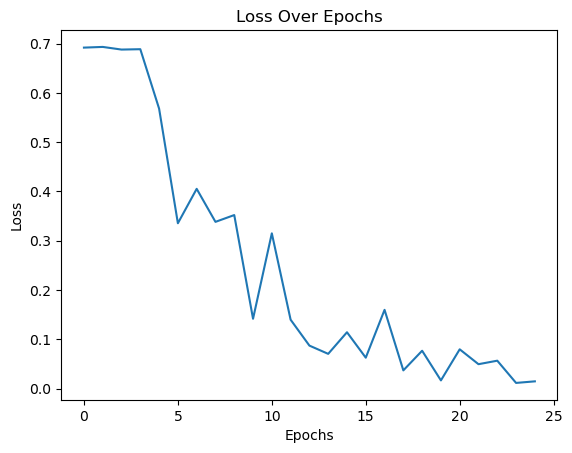

In [15]:
plt.plot(losses)
plt.title(label="Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show() 